## First BMI Experiment

#### Pre-calibration

* Choose targeted calibration movements

#### Calibration
* Collect calibration dataset 
* Run decomposition, save 

#### Pre-Game
* Run game multiple times to set "hyperparameters"
    * V_max -- 50mV (very light movements) 
        * This could be set via calibration itself? 
        * This could be set per-channel? 
    * Cursor decay -- 50 samples
    * Mappings themselves -- NMF 
    
#### Game
* record data 
* 

### Mapping Factorization

In [8]:
def load_and_preprocess_data(filepath):
    # open dataset
    dataset = xa.open_dataset(filepath)
    analysis.fill_time_array(dataset)
    # cut out start, rectify, smooth
    start_idx = 2000 # first second
#     drops = analysis.get_dropped_samples(dataset.counter.values)
#     return analysis.preprocess(dataset.emg.values[:,start_idx:])
    return causal_blur(analysis.rectify(analysis.demean(dataset.emg.values[:,start_idx:]*0.0002861)), half_gaussian(100))

# gaussian causal filter 
def gaussian(x, sig):
    sigma2 = sig * sig
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()
    return phi_x

def half_gaussian(sig, truncate=4):
    h = 2*sig
    x = np.arange(-h,0,1)
    return gaussian(x,sig)
def causal_blur(array, weights):
    return scipy.ndimage.correlate1d(array, weights, axis=1, mode='nearest')

In [2]:
import os 
import netCDF4 as nc 
import xarray as xa
import numpy as np
import time
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import analysis
import scipy.signal
from sklearn.decomposition import NMF
data_folder = Path('/Users/spencerw/data/2020-05-11-spencer/')

In [34]:
filenames = list(data_folder.rglob('*'))
data_paths = analysis.data_files(data_folder)


+ /Users/spencerw/data/2020-05-11-spencer
    + 1589216282_index_middle_ring_pinky_spencer.data


In [35]:
processed_emg = load_and_preprocess_data(data_paths[0])

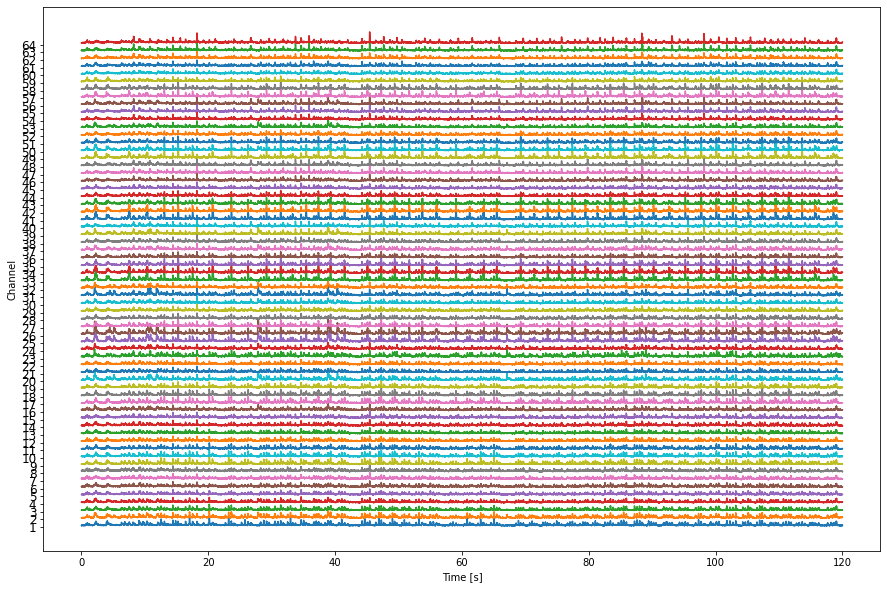

In [57]:
start_idx = 10000
end_idx = 250000
fig = analysis.plot_biolectric(processed_emg[:,start_idx:end_idx],offset=.01)

In [58]:
nmf = NMF(n_components=5, init='random', random_state=42)
nmf_components = []
# model takes (samples, features)
nmf.fit(processed_emg[:,start_idx:end_idx].T)    

NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

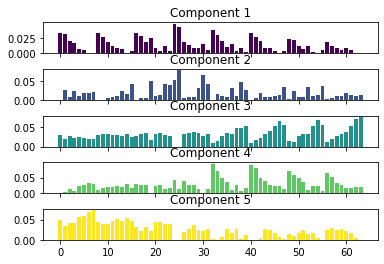

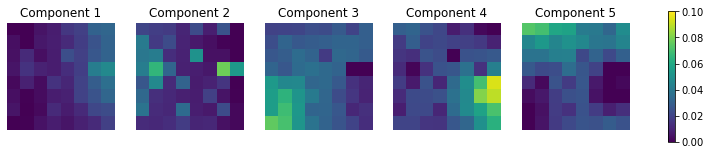

In [59]:
_ = analysis.plot_features_bar(nmf.components_)
_=analysis.plot_features_grid(nmf.components_,vmax=0.1)

[1. 1. 1. 1.]


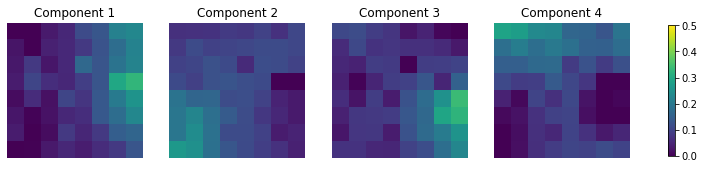

In [100]:
c = nmf.components_[[0,2,3,4]]/np.linalg.norm(nmf.components_[[0,2,3,4]],axis=1).reshape(-1,1)
print(np.linalg.norm(c,axis=1))
_ = analysis.plot_features_grid(c,vmax=.5)

[24 63 32  7]


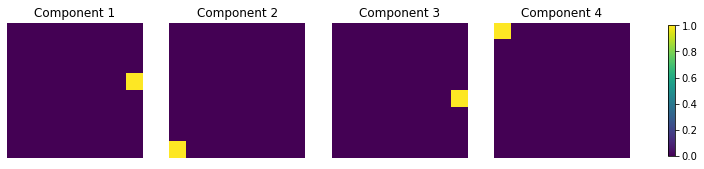

In [97]:
# find the channels with the max
max_chans = np.argmax(c,axis=1)
print(max_chans)
onehots = np.zeros((4,64))
for i, chan in zip(range(4),max_chans):
    onehots[i,chan] = 1
_ = analysis.plot_features_grid(onehots,vmax=1)

In [98]:
c

array([[0.23217243, 0.22012548, 0.13390451, 0.1141596 , 0.05484093,
        0.03567658, 0.        , 0.        , 0.22226049, 0.17957119,
        0.12806044, 0.08358415, 0.05764302, 0.04562302, 0.        ,
        0.02883932, 0.2237839 , 0.18978222, 0.13179636, 0.16821983,
        0.05747351, 0.02937878, 0.08309044, 0.03241477, 0.32970399,
        0.29693113, 0.13114945, 0.09231966, 0.05582269, 0.06587983,
        0.10354206, 0.03903777, 0.25733256, 0.20652456, 0.13857647,
        0.07655971, 0.10355063, 0.02211427, 0.06365827, 0.01659196,
        0.23158706, 0.17892469, 0.13697402, 0.06518303, 0.05541328,
        0.02368518, 0.00534156, 0.02985479, 0.16380214, 0.15004505,
        0.08324204, 0.05438055, 0.0838399 , 0.01684239, 0.00120867,
        0.03866047, 0.13225289, 0.08257783, 0.0632041 , 0.04026334,
        0.05587896, 0.03406469, 0.00363852, 0.        ],
       [0.10643099, 0.07101107, 0.09960413, 0.08053428, 0.08515799,
        0.07413961, 0.07042784, 0.0701795 , 0.10733323, 0.1